## Data Import

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

First we import our two main datasets that we will use for now. `counts_df` contains the transcript counts across 138 interest genes for the 5632 cells that are of useful genotype. `genotype_scores_df` contains the FACS and proliferation scores for each unique genotype, as well as their assigned cluster.

In [81]:
counts_df = pd.read_feather("interest_counts_df.feather")
print(counts_df.shape)

genotype_scores_df = pd.read_feather("genotype_df.feather")
genotype_scores_df.head()

(5632, 138)


,unique_genotypes,facs_score,proliferation_score,custom_clusters
0,64844886-1/1/1-C-T;64844887-1/1/1-C-T;64844889...,16.508,10.304,2.0
1,64844181-1/1/1-C-T;64844183-1/1/1-C-T;64844198...,19.571,13.976,2.0
2,64844855-1/1/1-G-A,0.453,-2.231,1.0
3,64850886-1/1/1-G-A;64850904-0/0/1-G-A,-2.531,4.017,1.0
4,64857775-1/1/1-C-T;64857780-1/1/1-C-T,17.049,11.551,2.0


Re-visualisation of the labelled clusters: low FACS and low proliferation, high FACS and high proliferation, intermediate FACS and intermediate-to-high proliferation.

Text(0, 0.5, 'Proliferation Score')

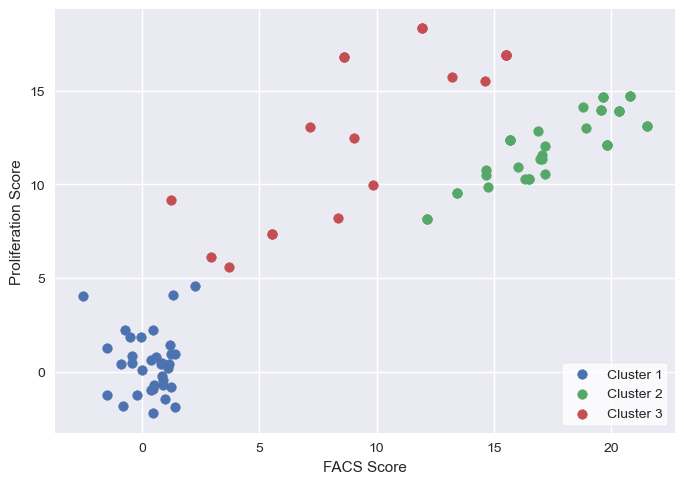

In [82]:
fig, ax = plt.subplots()

cluster_1_facs = genotype_scores_df.loc[genotype_scores_df["custom_clusters"] == 1, "facs_score"]
cluster_2_facs = genotype_scores_df.loc[genotype_scores_df["custom_clusters"] == 2, "facs_score"]
cluster_3_facs = genotype_scores_df.loc[genotype_scores_df["custom_clusters"] == 3, "facs_score"]
cluster_1_proliferation = genotype_scores_df.loc[genotype_scores_df["custom_clusters"] == 1, "proliferation_score"]
cluster_2_proliferation = genotype_scores_df.loc[genotype_scores_df["custom_clusters"] == 2, "proliferation_score"]
cluster_3_proliferation = genotype_scores_df.loc[genotype_scores_df["custom_clusters"] == 3, "proliferation_score"]

ax.scatter(cluster_1_facs, cluster_1_proliferation, label = "Cluster 1")
ax.scatter(cluster_2_facs, cluster_2_proliferation, label = "Cluster 2")
ax.scatter(cluster_3_facs, cluster_3_proliferation, label = "Cluster 3")

ax.legend(loc = "lower right", frameon = True, facecolor = "white")
ax.set_xlabel("FACS Score")
ax.set_ylabel("Proliferation Score")

Addition of the clusters from `genotype_scores_df` to each row of `counts_df` to be the label in the classifier:

In [83]:
label_cluster = []

for i in range(len(counts_df)):
    index = genotype_scores_df.index[genotype_scores_df["unique_genotypes"] == counts_df["GT"][i]]
    label_cluster.append(genotype_scores_df["custom_clusters"][index].values[0])

counts_df.insert(1, "label_cluster", label_cluster)

print(Counter(counts_df["label_cluster"]))

Counter({2.0: 2989, 1.0: 2062, 3.0: 581})


Create a ensembl ID to gene name conversion table:

In [84]:
# Import ensembl ID to gene name conversion data frame
id_convert_df = pd.read_csv("JAK_STAT pathway genes.csv")

id_convert_df.head()

,initial_alias,converted_alias,name,description,namespace
0,AKT1,ENSG00000142208,AKT1,AKT serine/threonine kinase 1 [Source:HGNC Sym...,"ENTREZGENE,GENECARDS,HGNC,UNIPROT_GN,WIKIGENE"
1,AKT2,ENSG00000105221,AKT2,AKT serine/threonine kinase 2 [Source:HGNC Sym...,"ENTREZGENE,GENECARDS,HGNC,UNIPROT_GN,WIKIGENE"
2,AKT3,ENSG00000117020,AKT3,AKT serine/threonine kinase 3 [Source:HGNC Sym...,"ENTREZGENE,GENECARDS,HGNC,UNIPROT_GN,WIKIGENE"
3,BCL2L1,ENSG00000171552,BCL2L1,BCL2 like 1 [Source:HGNC Symbol;Acc:HGNC:992],"ENTREZGENE,GENECARDS,HGNC,UNIPROT_GN,WIKIGENE"
4,CBL,ENSG00000110395,CBL,Cbl proto-oncogene [Source:HGNC Symbol;Acc:HGN...,"ENTREZGENE,GENECARDS,HGNC,UNIPROT_GN,WIKIGENE"


## Pymoo Optimisation

Test optimisation

In [ ]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.indicators.hv import HV
from pymoo.core.sampling import Sampling

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

In [ ]:
# ------------------
# Define Constants
# ------------------

# Desired defaults: 400, 25, 10, (True, 20), np.array(["ENSG00000162434"]), np.array([140, 0]), "balanced accuracy"

pop_size = 100
n_generations = 20
initial_features = 10
maximum_features = (True, 20)
required_features = np.array(["ENSG00000162434"]) # JAK1
hv_reference_point = np.array([140, 0])
evaluation_metric = "balanced accuracy"

In [11]:
# -----------------
# Define Datasets
# -----------------

counts_data = counts_df.iloc[:, 2:]
labels_data = counts_df["label_cluster"]

In [70]:
# --------------------------------
# Implement Optimisation Methods
# --------------------------------

class FixedFeatureSampling(Sampling):
    def __init__(self, num_features = 10, required_features = np.array([])):
        self.num_features = num_features
        self.vtype = bool
        self.repair = None
        self.required_features = required_features

    def _do(self, problem, n_samples, **kwargs):
        # Get indices of all required genes
        required_indices = []
        for i in range(len(self.required_features)):
            required_indices.append(counts_data.columns.get_loc(self.required_features[i]))

        # Start with all zeros
        pop = np.zeros((n_samples, problem.n_var)) 

        # Create initial list to select from for initial population
        select_from_indices = list(range(problem.n_var))
        for index in required_indices:
            # Ensure that required indices cannot be selected at random too
            select_from_indices.remove(index)

        for i in range(n_samples):
            # Pick a random solution length between at least 2 and at most the num_features argument
            random_solution_length = np.random.randint(np.max([2, len(required_indices) + 1]), self.num_features + 1)
            # Ensures always at least 1 feature at random included in solution
            selected_indices = np.random.choice(select_from_indices, random_solution_length - len(required_indices), replace = False)

            # Add the required indices
            selected_indices = np.append(selected_indices, required_indices)

            pop[i, selected_indices] = 1  # Activate exactly 10 features

        return pop

# ----------------------------
# Implement ClassifyOptimise
# ----------------------------

class ClassifyOptimise(Problem):
    def __init__(self, data, labels, max_features, required_features, evaluation_metric):
        super().__init__(n_var=data.shape[1],   # Number of features
                         n_obj=2,               # Two objectives
                         n_constr=0,            # No constraints
                         xl=0,                  # Lower bound (feature excluded)
                         xu=1)                  # Upper bound (feature included)
        self.data = data
        self.labels = labels
        self.feature_limit = max_features[0]
        self.max_features = max_features[1]
        self.required_features = required_features
        self.evaluation_metric = evaluation_metric
        self.generation_number = 0
    

    def _evaluate(self, x, out, *args, **kwargs):
        """
        Evaluate each generation.
        """
        # Update generation number and print to the user
        self.generation_number += 1

        print(f"Evaluating generation {self.generation_number}")

        # Enforce a feature limit: At most max_features features selected
        if self.feature_limit == True:
            x = self.impose_feature_limit(x, self.max_features)

        # Ensure required features are included on each solution
        if len(self.required_features) > 0:
            x = self.impose_required_features(x, self.required_features)

        # Objective 1: Minimize the number of features
        f1 = np.sum(x, axis=1)

        # Objective 2: Maximize classification performance metric
        f2 = np.array([-self.evaluate_performance(individual, self.evaluation_metric) for individual in x])

        # Return objective values
        out["F"] = np.column_stack([f1, f2])
    

    def evaluate_performance(self, x, evaluation_metric):
        """
        Performs support vector machine classification and returns the evaluation of the predicted labels.

        Args:
            x: Solutions.
        
        Returns:
            evaluation (float): The calculated evaluation metric for the support vector machine.
        """
        selected_features = x.astype(bool)
        X = self.data.loc[:, selected_features]

        # Punish the algorithm for selecting 0 features
        if X.shape[1] == 0:
            return 0.0
        
        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, self.labels, test_size = 0.2)

        # Train a classifier (e.g., Random Forest, SVC)
        clf = SVC(kernel = "rbf", class_weight = "balanced") # class_weight = "balanced" auto-adjusts weights based on class frequencies
        clf.fit(X_train, y_train)

        # Predict on test set
        y_pred = clf.predict(X_test)

        print(f"1.0: {len(y_pred[y_pred == 1.0])}, 2.0: {len(y_pred[y_pred == 2.0])}, 3.0: {len(y_pred[y_pred == 3.0])}")

        # Evaluate classifier
        if evaluation_metric == "accuracy":
            evaluation = accuracy_score(y_test, y_pred)
        elif evaluation_metric == "minority class f1":
            evaluation = f1_score(y_test, y_pred, labels = [3.0], average = "macro")
        elif evaluation_metric == "balanced accuracy":
            evaluation = balanced_accuracy_score(y_test, y_pred)

        print(f"Number of features: {X.shape[1]}; Evaluation metric: {evaluation:.4f}")

        return evaluation
    
    # -------------------
    # Optional Features
    # -------------------

    def impose_feature_limit(self, x, max_features):
        """
        Used for ensuring that a solution cannot contain more than max_features number of features.
        Note: required features are currently added after this function is applied.

        Args:
            x: Solutions.
            max_features (int): The maximum allowable number of features a solution may select.
        
        Returns:
            x: Updated.
        """
        # Enforce a feature limit: At most max_features features selected
        for i in range(x.shape[0]):  
            selected_features = np.sum(x[i]) 
            
            # If more than max_feature features are selected, randomly remove some
            if selected_features > max_features:
                selected_indices = np.where(x[i] == 1)[0]
                np.random.shuffle(selected_indices)
                x[i, selected_indices[:selected_features - max_features]] = 0
        
        return x
    

    def impose_required_features(self, x, required_features):
        """
        Used for requiring that certain genes be used as a feature on each solution.

        Args:
            x: Solutions.
            required_features (list): A list of genes to be required on every solution.
        
        Returns:
            x: Updated.
        """
        # Get the column indices of our list of required features
        required_indices = []
        for i in range(len(required_features)):
            required_indices.append(counts_data.columns.get_loc(required_features[i]))

        # Get the lists of features currently included in each solution
        for i in range(x.shape[0]): 
            selected_indices = np.where(x[i] == 1)[0]

            # Checks if each required index is currently present.
            # If not, adds it to the list
            for j in range(len(required_indices)):
                if required_indices[j] not in selected_indices:
                    x[i, required_indices[j]] = 1
                    print(f"Required addition of gene {required_indices[j]}")

        return x


In [72]:
# ------------------------
# NSGA-II Implementation
# ------------------------

pareto_fronts = []


algorithm = NSGA2(pop_size = pop_size,
                  sampling = FixedFeatureSampling(num_features = initial_features,
                                                  required_features = required_features),
                  crossover = TwoPointCrossover(),
                  mutation = BitflipMutation(),
                  callback = lambda algorithm_instance: pareto_fronts.append(algorithm_instance.result()))

res = minimize(problem = ClassifyOptimise(data = counts_data, 
                                          labels = labels_data, 
                                          max_features = maximum_features,
                                          required_features = required_features,
                                          evaluation_metric = evaluation_metric),
               algorithm = algorithm,
               termination = ('n_gen', n_generations),
               verbose = False)

print("Optimisation terminated.")

for i, pareto_front in enumerate(pareto_fronts):
    print(f"Generation {i+1}: Pareto front")
    print(pareto_fronts[i].F)
    
    ind = HV(ref_point = hv_reference_point)
    print(f"Hypervolume for Generation {i+1}: {ind(pareto_fronts[i].F)}")

Evaluating generation 1
1.0: 304, 2.0: 810, 3.0: 13
Number of features: 5; Evaluation metric: 0.3773
1.0: 302, 2.0: 816, 3.0: 9
Number of features: 5; Evaluation metric: 0.3815
1.0: 263, 2.0: 851, 3.0: 13
Number of features: 5; Evaluation metric: 0.3679
1.0: 348, 2.0: 653, 3.0: 126
Number of features: 10; Evaluation metric: 0.3543
1.0: 256, 2.0: 855, 3.0: 16
Number of features: 2; Evaluation metric: 0.3693
1.0: 274, 2.0: 820, 3.0: 33
Number of features: 3; Evaluation metric: 0.3730
1.0: 322, 2.0: 720, 3.0: 85
Number of features: 9; Evaluation metric: 0.3789
1.0: 242, 2.0: 673, 3.0: 212
Number of features: 4; Evaluation metric: 0.3708
1.0: 296, 2.0: 830, 3.0: 1
Number of features: 7; Evaluation metric: 0.3861
1.0: 316, 2.0: 657, 3.0: 154
Number of features: 7; Evaluation metric: 0.3887
1.0: 258, 2.0: 847, 3.0: 22
Number of features: 9; Evaluation metric: 0.3815
1.0: 303, 2.0: 809, 3.0: 15
Number of features: 5; Evaluation metric: 0.3688
1.0: 297, 2.0: 612, 3.0: 218
Number of features: 9

## Data Visualisation

In [73]:
from pymoo.visualization.scatter import Scatter
import matplotlib.pyplot as plt

C:\Users\miles\AppData\Local\Temp\ipykernel_13240\2289505073.py:42: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



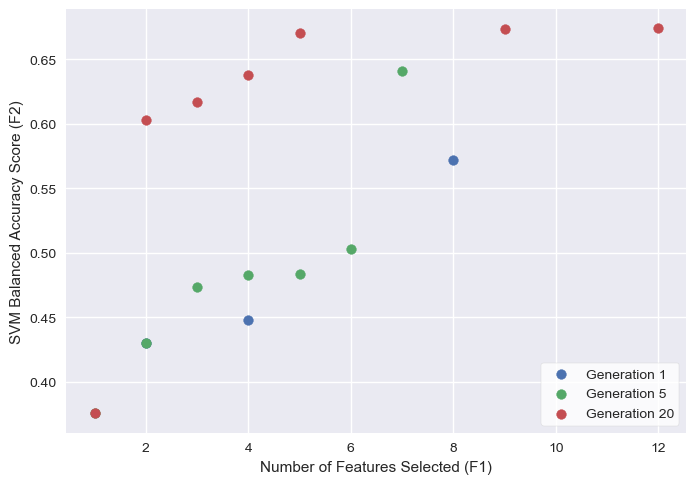

In [76]:
def create_custom_pareto(pareto_fronts, n_generations = n_generations):
    # Defines indices of the generations I'd like to plot
    first_gen = 0
    middle_gen = int(np.ceil(n_generations / 6))
    final_gen = n_generations - 1

    # Extract first_gen points
    first_gen_x = []
    first_gen_y = []
    for i in range(len(pareto_fronts[first_gen].F)):
        first_gen_x.append(pareto_fronts[first_gen].F[i][0])
        first_gen_y.append(pareto_fronts[first_gen].F[i][1] * (-1))

    # Extract middle_gen points
    middle_gen_x = []
    middle_gen_y = []
    for i in range(len(pareto_fronts[middle_gen].F)):
        middle_gen_x.append(pareto_fronts[middle_gen].F[i][0])
        middle_gen_y.append(pareto_fronts[middle_gen].F[i][1] * (-1))

    # Extract final_gen points
    final_gen_x = []
    final_gen_y = []
    for i in range(len(pareto_fronts[final_gen].F)):
        final_gen_x.append(pareto_fronts[final_gen].F[i][0])
        final_gen_y.append(pareto_fronts[final_gen].F[i][1] * (-1))

    # Begin plotting
    plt.style.use('seaborn-v0_8')
    fig, ax = plt.subplots()

    # Add each of our 3 pareto fronts
    ax.scatter(first_gen_x, first_gen_y, label = f"Generation {first_gen + 1}")
    ax.scatter(middle_gen_x, middle_gen_y, label = f"Generation {middle_gen + 1}")
    ax.scatter(final_gen_x, final_gen_y, label = f"Generation {final_gen + 1}")

    ax.set_xlabel("Number of Features Selected (F1)")
    ax.set_ylabel("SVM Balanced Accuracy Score (F2)")

    ax.legend(loc = "lower right", frameon = True, facecolor = "white")

    fig.show()


create_custom_pareto(pareto_fronts, n_generations)


In [63]:
import plotly.express as px

In [78]:
def convert_indices_to_gene_list(boolean_vector, dataset):
    """
    Take a boolean array and converts it a list of genes from the column ids of
    the given dataset
    """
    indices = np.where(boolean_vector)[0]

    gene_list = []

    for index in indices:
        gene = convert_index_to_gene(index, dataset)
        gene_list.append(gene)

    return gene_list


def convert_index_to_gene(index, dataset):#
    """
    Converts a single index from a column id to its ensembl id and returns the gene name"
    """
    ensembl_id = dataset.columns[index]

    gene = id_convert_df.loc[id_convert_df["converted_alias"] == ensembl_id, "initial_alias"].values[0]

    return gene


def create_interactive_pareto(pareto_fronts, n_generations = n_generations):
    # Defines indices of the generations I'd like to plot
    first_gen = 0
    middle_gen = int(np.ceil(n_generations / 6))
    final_gen = n_generations - 1

    # Extract first_gen points
    first_gen_x = []
    first_gen_y = []
    first_gen_solutions = []
    for i in range(len(pareto_fronts[first_gen].F)):
        first_gen_x.append(pareto_fronts[first_gen].F[i][0])
        first_gen_y.append(pareto_fronts[first_gen].F[i][1] * (-1))
        first_gen_solutions.append(convert_indices_to_gene_list(pareto_fronts[first_gen].X[i], 
                                                                 counts_data))

    # Extract middle_gen points
    middle_gen_x = []
    middle_gen_y = []
    middle_gen_solutions = []
    for i in range(len(pareto_fronts[middle_gen].F)):
        middle_gen_x.append(pareto_fronts[middle_gen].F[i][0])
        middle_gen_y.append(pareto_fronts[middle_gen].F[i][1] * (-1))
        middle_gen_solutions.append(convert_indices_to_gene_list(pareto_fronts[middle_gen].X[i], 
                                                                 counts_data))

    # Extract final_gen points
    final_gen_x = []
    final_gen_y = []
    final_gen_solutions = []
    for i in range(len(pareto_fronts[final_gen].F)):
        final_gen_x.append(pareto_fronts[final_gen].F[i][0])
        final_gen_y.append(pareto_fronts[final_gen].F[i][1] * (-1))
        final_gen_solutions.append(convert_indices_to_gene_list(pareto_fronts[final_gen].X[i], 
                                                                 counts_data))

    # Build the pandas data frame for the interactive plot
    x = first_gen_x + middle_gen_x + final_gen_x
    y = first_gen_y + middle_gen_y + final_gen_y
    front_a = [f"Generation {first_gen + 1}"] * len(first_gen_x)
    front_b = [f"Generation {middle_gen + 1}"] * len(middle_gen_x)
    front_c = [f"Generation {final_gen + 1}"] * len(final_gen_x)
    front = front_a + front_b + front_c
    solutions = first_gen_solutions + middle_gen_solutions + final_gen_solutions
    
    df = pd.DataFrame({
        "Number of Features Selected (F1)": x,
        "SVM Balanced Accuracy Score (F2)": y,
        "Pareto Front": front,
        "solutions": solutions
    })

    # Converts solution lists into a more readable format for the hover tooltip
    df["Genes"] = df["solutions"].apply(lambda x: "<br>".join(x))

    # Create plotly plot
    plt.style.use('seaborn-v0_8')
    fig = px.scatter(df, x = "Number of Features Selected (F1)", 
                     y = "SVM Balanced Accuracy Score (F2)", color = "Pareto Front",
                     title = "Interactive Pareto Front",
                     hover_data = {"Number of Features Selected (F1)": False, 
                                   "SVM Balanced Accuracy Score (F2)": False, 
                                   "Pareto Front": False, 
                                   "Genes": True})
    
    fig.update_layout(width = 800, height = 600)
    
    fig.show()


create_interactive_pareto(pareto_fronts, n_generations)

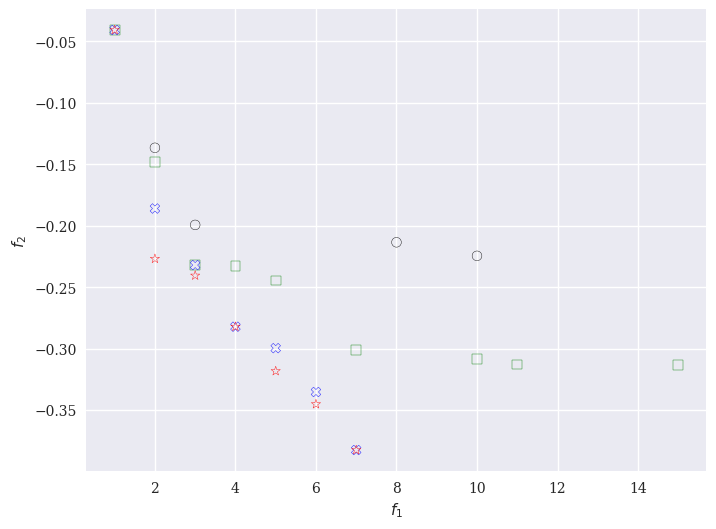

In [67]:
plot = Scatter()
plot.add(pareto_fronts[1].F, facecolor = "none", 
         edgecolor = "black", marker = "o", label = "Generation 2")
plot.add(pareto_fronts[7].F, facecolor = "none", 
         edgecolor = "green", marker = "s", label = "Generation 8")
plot.add(pareto_fronts[13].F, facecolor = "none", 
         edgecolor = "blue", marker = "X", label = "Generation 14")
plot.add(pareto_fronts[19].F, facecolor = "none", 
         edgecolor = "red", marker = "*", label = "Generation 20")

plot.show()